In [60]:
import xarray as xr
import numpy as np
import datacube
import geopandas as gpd
import scipy.interpolate as interpolate
from rasterio import features
import pandas as pd

# Connect to current collection and collection upgrade databases
dc = datacube.Datacube()

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools, DEADataHandling

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set parameters

In [96]:
waterbody_path = '/g/data/r78/WaterHack/Lidar/waterbody_clip.shp'
lidar_path = '/g/data/r78/WaterHack/Lidar/LiDAR_1m_Namoi_NarrabriTown_2014_55.tif'

## Load extent polygon

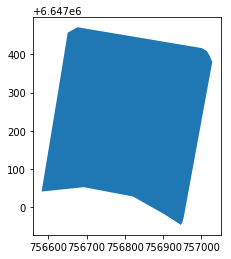

In [97]:
polygon_gdf = gpd.read_file(waterbody_path)
polygon_gdf = polygon_gdf.to_crs(epsg = 28355)
polygon_gdf.plot()

## Load LiDAR data

In [98]:
# Load as an xarray format dataset. The `chunks` option uses dask to break the 
# raster into smaller chunks, and not load any data unless it is requested with
# `.compute()`. This can be useful for large datasets like high-res LiDAR data,
# which will cause memory issues and run very slowly if loaded all in one go.
lidar_data = xr.open_rasterio(lidar_path, chunks={'x': 500, 'y': 500})
lidar_data

<xarray.DataArray (band: 1, y: 26000, x: 32000)>
dask.array<shape=(1, 26000, 32000), dtype=float32, chunksize=(1, 500, 500)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.654e+06 6.654e+06 6.654e+06 ... 6.628e+06 6.628e+06
  * x        (x) float64 7.52e+05 7.52e+05 7.52e+05 ... 7.84e+05 7.84e+05
Attributes:
    transform:   (1.0, 0.0, 752000.0001220703, 0.0, -1.0, 6654000.00012207)
    crs:         PROJCS["GDA_1994_MGA_Zone_55",GEOGCS["GCS_GDA_1994",DATUM["G...
    res:         (1.0, 1.0)
    is_tiled:    1
    nodatavals:  (-3.402823e+38,)

## Clip and mask LiDAR to extent of polygon

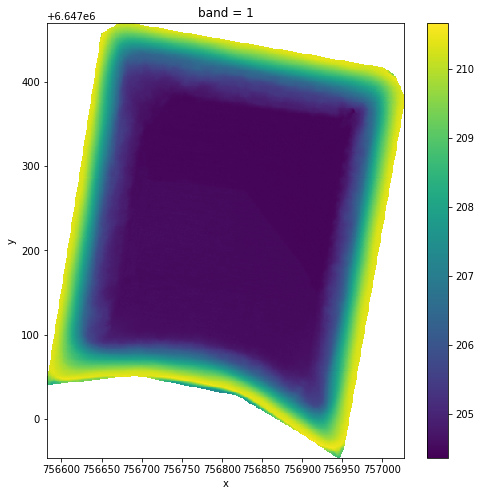

In [99]:
# Clip LiDAR dataset to the extent of the waterbody polygon
lidar_subset = lidar_data.sel(x = (lidar_data.x > polygon_gdf.bounds.minx.item()) & 
                                  (lidar_data.x < polygon_gdf.bounds.maxx.item()),
                              y = (lidar_data.y > polygon_gdf.bounds.miny.item()) & 
                                  (lidar_data.y < polygon_gdf.bounds.maxy.item()))

# Update transform object. This allows us to later create a shapefile mask based
# on the extents of the clipped LiDAR dataset
new_transform = list(lidar_data.transform)
new_transform[2] = (lidar_subset.x.min() - lidar_data.transform[0] * 0.5).item()
new_transform[5] = (lidar_subset.y.max() - lidar_data.transform[4] * 0.5).item()
lidar_subset.attrs['transform'] = tuple(new_transform)

# Identify all geometry objects in shapefile
shapes = [(shape, n) for n, shape in enumerate(polygon_gdf.geometry)]

# Generate mask from shapefile
xarray_mask = features.rasterize(shapes, out_shape=lidar_subset.shape[1:],
                                 fill=np.nan, transform=lidar_subset.transform,
                                 all_touched=True, dtype=np.float)

# Apply mask to LiDAR dataset and load data into memory using `.compute()`
lidar_subset = lidar_subset.where(np.expand_dims(np.isfinite(xarray_mask), axis=0))
lidar_subset = lidar_subset.compute()
lidar_subset.plot(figsize=(8,8))

### Create volume to elevation curve

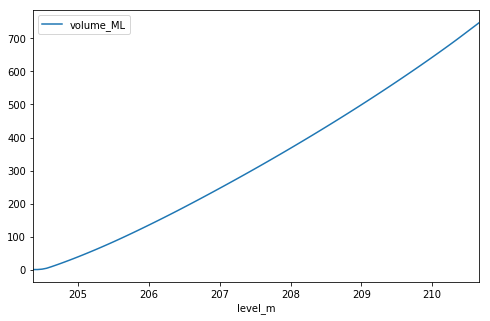

In [100]:
levels_volumes = []

for level_m in np.linspace(lidar_subset.min(), lidar_subset.max(), 100):
    
    # Create a flat array with values set to the given water level
    water_level = np.full(lidar_subset.shape[1:], level_m)
    
    # Subtract LiDAR DEM from this water level array to create an array giving the 
    # difference between this water level and the true elevation of each pixel
    water_level_diffs = water_level - lidar_subset
    
    # By restricting these differences to only pixels where the water level is
    # higher than the underlying LiDAR DEM (i.e. positive values), we can get
    # depths for every pixel
    water_level_depths = water_level_diffs.where(water_level_diffs > 0)
    
    # By multiplying depths by the area of each pixel (obtained from the resolution
    # of the LiDAR raster), we can compute volumes in cubic metres for each pixel
    water_level_volumes = water_level_depths * (lidar_subset.res[0] * lidar_subset.res[1])
    
    # Finally, sum the volumes of all pixels and multiply by 0.001 to get total 
    # waterbody volume in megaliters (Ml) for the given water level height
    total_volume = water_level_volumes.sum().item() * 0.001

    # Append water level height and total volume to list    
    levels_volumes.append((level_m, total_volume))  
    
# Combine into a single dataframe comparing water levels (m) and volumes (ML)
level_to_volume = pd.DataFrame(levels_volumes, columns=['level_m', 'volume_ML'])
level_to_volume.plot(x='level_m', y='volume_ML', figsize=(8, 5))
    